### Volatility Estimator

This simple project provides users with a basic a tool that computes and compare different volatility measures on the same asset (stocks, bonds, cryptocurrencies etc). 

To visualise historical volatility, we will use log returns and then add rolling windows (20, 60, 120 days) to illustrate change and senstivity. We will be varying the measure with the inclusion of an EWMA version to capture recent shocks faster. Following that, we will extend it by comparing realized volatility before and after macro events like CPI or CB meetings.

To illustrate the volatilities of assets to an index, we will also be comparing their performance and movements across time.

Some key volatility measures that we will be using include the following:

##### 1) Simple Rolling Windows:

This involve the calculation of the rolling mean of the given asset across time. This can be expressed as follow:
$$
\text{RollingMean}_t = \frac{1}{n}\sum_{i=0}^{n-1} \log\left(\frac{P_{t-i}}{P_{t-i-1}}\right)
$$
We compute the log returns of the asset and, given a rolling window of length \( n \), derive the average of all log returns within the lookback period. Similarly, rolling **historical volatility** is computed as the standard deviation of log returns over the same window:
$$
\sigma_t^{\text{rolling}} = \sqrt{\frac{1}{n-1}\sum_{i=0}^{n-1}\left(r_{t-i} - \bar{r}_t\right)^2}
$$
where:

$$
r_t = \log\left(\frac{P_t}{P_{t-1}}\right)
$$
Rolling windows treat all observations within the window equally, which makes them simple and interpretable but slower to react to recent shocks.

##### 2. Exponential-Weighted Moving Average (EWMA)

EWMA assigns greater weight to more recent returns, allowing volatility estimates to respond faster to sudden market movements. The EWMA volatility is defined recursively as:

$$
\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1 - \lambda) r_t^2
$$

where:
- $r_t$ is the log return at time $t$ 
- $\lambda \in (0,1)$ is the decay factor (commonly $\lambda = 0.94$ for daily data)

Unlike simple rolling windows, EWMA does not rely on a fixed lookback period and implicitly incorporates the full return history with exponentially decaying weights. This makes EWMA particularly useful for capturing **volatility clustering** and rapid changes following macroeconomic events or market shocks.

##### 3. Realised Volatility

Realised volatility measures the **actual historical variability of an asset** over a given period, typically calculated from high-frequency or daily returns. It is often used as a benchmark to compare against model-based volatility estimates, such as rolling or EWMA volatilities.  

- **Definition (using daily log returns):**

$$
\text{RealisedVol}_t = \sqrt{\sum_{i=1}^{n} r_{t-i+1}^2}
$$

where:

$$
r_t = \log\left(\frac{P_t}{P_{t-1}}\right)
$$

- **Interpretation:**  
  - Captures the **total variability** observed in returns over a period.  
  - Unlike rolling or EWMA volatilities, realised volatility does **not apply weighting** or smoothing—it reflects what actually happened.  

- **Annualisation:** For daily data, realised volatility is often annualised using:

$$
\text{RealisedVol}^{\text{annual}}_t = \text{RealisedVol}_t \cdot \sqrt{252}
$$

where 252 is the approximate number of trading days in a year.  

In [124]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import requests
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

Initialise the Parameters

In [125]:
benchmark_symbol = "SPY"
start = "2018-01-01"
end = "2025-12-31"
frequency = "1d"

# Periods of Black Swan Events or Macro Shocks
macro_shocks = {
  "Global Financial Crisis": ("2008-09-15", "2009-03-09"),
  "European Debt Crisis": ("2010-04-23", "2012-07-31"),
  "US Debt Ceiling Crisis & S&P Downgrade": ("2011-07-25", "2011-10-14"),
  "Chinese Stock Market Turbulence": ("2015-06-12", "2015-09-30"),
  "Brexit Referendum": ("2016-06-23", "2016-07-11"),
  "2018 Stock Market Sell-Off": ("2018-01-26", "2018-02-08"),
  "COVID-19 Pandemic": ("2020-02-20", "2020-03-23"),
  "Russia–Ukraine War": ("2022-02-24", "2022-03-08"),
  "US Regional Banking Crisis (SVB, Signature)": ("2023-03-08", "2023-03-17"),
}

Retrieve all the stock tickers from Wikipedia

In [126]:
headers = {
  "User-Agent": "Mozilla/5.0"
}
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url, headers=headers)
sp500 = pd.read_html(response.text)[0]
tickers = sp500["Symbol"].tolist()
print("Number of S&P 500 tickers fetched:", len(tickers))

Number of S&P 500 tickers fetched: 503


Retrieve our data

In [127]:
def retrieve_stock_data(tickers, start, end, frequency):
  dataset= {}
  for ticker in tickers:
    data = yf.download(ticker, start=start, end=end, interval=frequency)
    
    # Clean the data by dropping rows with missing values and retaining only the closing price and volume columns
    data = data.dropna()[["Close", "Volume"]]
    data.columns = [col[0] for col in data.columns]
    data.reset_index(inplace=True)
    if not data.empty:
      dataset[ticker] = data
  return dataset

In [128]:
# Call our data retrieval function

# Instead of downloading the entire dataset, we will focus on just a few tickers for demonstration
sp_500_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "BRK-B", "JPM", "JNJ", "V"]
sp_500_data = retrieve_stock_data(sp_500_tickers, start, end, frequency)

# Download the benchmark data
spy_data = retrieve_stock_data([benchmark_symbol], start, end, frequency)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Visualise the plots of the stock prices

In [129]:
def plot_pricing_data(dataset):
  plt.figure(figsize=(21, 8))
  for ticker, data in dataset.items():
    plt.plot(data["Date"], data["Close"], label=ticker)
  plt.title("Stock Closing Prices Over Time")
  plt.xlabel("Date")
  plt.ylabel("Closing Price (USD)")
  plt.legend()
  plt.grid()
  plt.show()

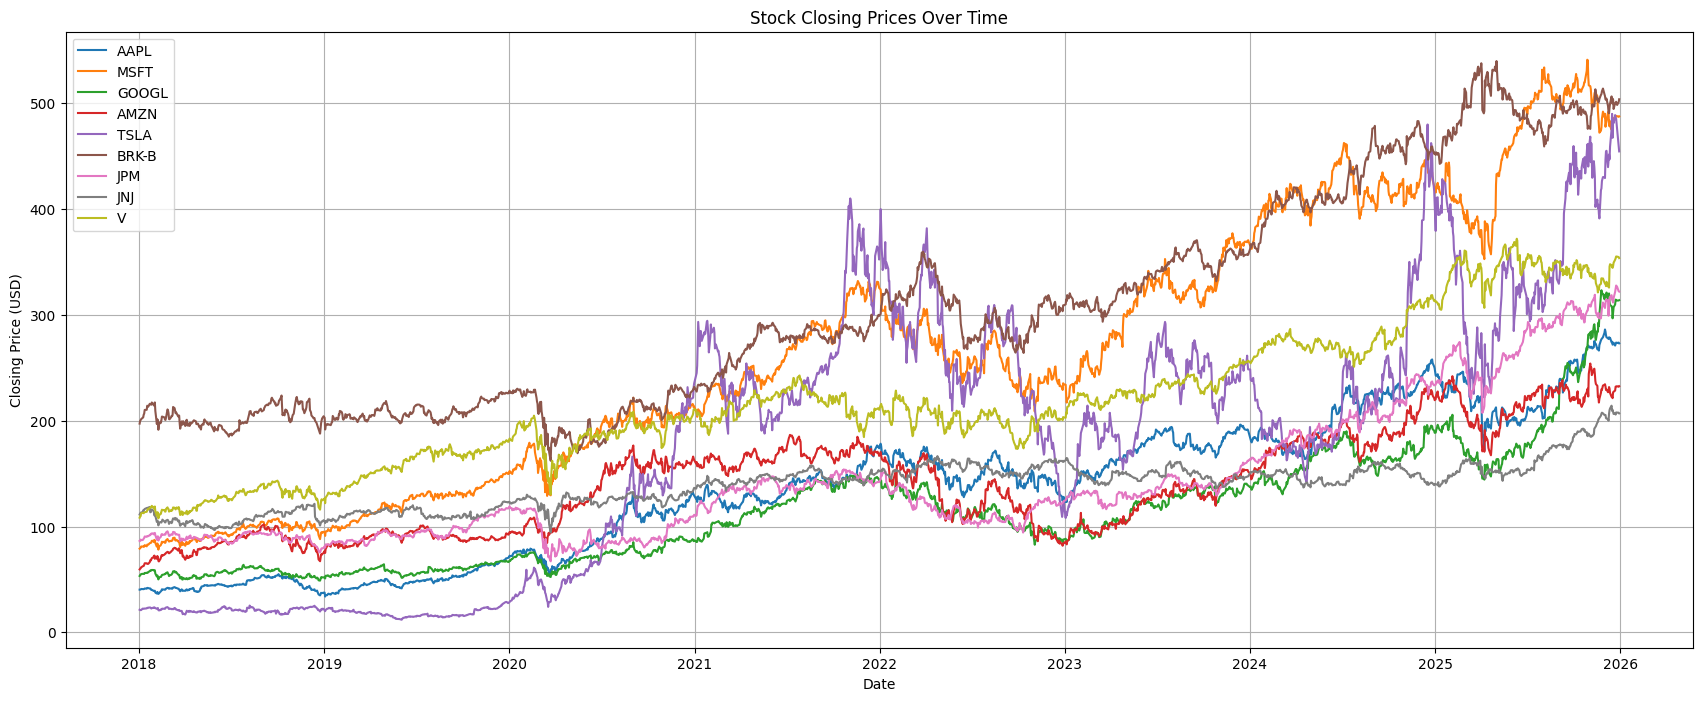

In [130]:
plot_pricing_data(sp_500_data)

Volatility Estimates Function

In [131]:
def compute_sma(data, window):
  return data["Log Return"].rolling(window=window).mean()
  
def compute_ema(data, span):
  return data["Log Return"].ewm(span=span, adjust=False).mean()

def realised_volatility(data, window):
  return np.sqrt((data["Log Return"]**2).rolling(window).sum())

Compute the log returns of our assets

In [132]:
def log_return(dataframe):
  log_df = pd.DataFrame()
  log_ret = np.log(dataframe["Close"] / dataframe["Close"].shift(1))
  log_df["Log Return"] = log_ret
  
  # Set index to be date from original dataframe
  log_df.index = dataframe["Date"]
  log_df.dropna(inplace=True)
  return log_df


Methods for Volatility Visualisation

In [133]:
def volatility_visual(dataset, ticker, start_date, end_date):
  # Make a copy of the dataframe
  df = dataset[ticker].copy()
  
  # Subset the data for the specified date range
  df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
  
  # Compute log returns
  lr = log_return(df)
  
  # 1. Compute the SMAs of varying windows
  sma_20 = compute_sma(lr, window=20)
  sma_60 = compute_sma(lr, window=60)
  sma_120 = compute_sma(lr, window=120)
  
  # Calculate the EWMA with varying spans
  ema_20 = compute_ema(lr, span=20)
  ema_60 = compute_ema(lr, span=60)
  ema_120 = compute_ema(lr, span=120)
  
  # Compute the realised volatility
  rv_5 = realised_volatility(lr, window=5)
  rv_10 = realised_volatility(lr, window=10)
  rv_20 = realised_volatility(lr, window=20)
  rv_60 = realised_volatility(lr, window=60)
  rv_120 = realised_volatility(lr, window=120)
  
  # 6 subplots stacked vertically, making each subplot having a different aspect of the data
  fig, axs = plt.subplots(6, 1, figsize=(21, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 2, 1, 1]})  # adjust each row's height
  
  # Concat all the SMAs and EMAs with our price data for plotting and drop NA values
  plot_data = pd.concat([df.set_index("Date")[["Close", "Volume"]], lr, sma_20, sma_60, sma_120, ema_20, ema_60, ema_120, rv_5, rv_10, rv_20, rv_60, rv_120], axis=1).dropna()
  plot_data.columns = [
    "Close", "Volume", "Log Return", "SMA 20", "SMA 60", "SMA 120", "EMA 20", "EMA 60", "EMA 120", "Realised Volatility 5", 
    "Realised Volatility 10", "Realised Volatility 20", "Realised Volatility 60", "Realised Volatility 120"
  ]
  plot_data.reset_index(inplace=True)
  
  # First chart will be price along with vertical boxes for macro shocks
  axs[0].plot(plot_data["Date"], plot_data["Close"], label="Closing Price", color="black")
  
  # Include the macro shocks as vertical boxes
  for shock, (start_date, end_date) in macro_shocks.items():
    # Convert to datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Check if dates are in the plotting range
    if start >= plot_data["Date"].min() and end <= plot_data["Date"].max():  
      axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[2].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[3].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[4].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[5].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
  
  axs[0].set_title(f"Closing Price for {ticker}")
  axs[0].set_ylabel("Price (USD)")
  axs[0].grid()
  axs[0].legend()
  
  # Second chart will be SMAs
  axs[1].plot(plot_data["Date"], plot_data["SMA 20"], label="SMA 20", color="blue")
  axs[1].plot(plot_data["Date"], plot_data["SMA 60"], label="SMA 60", color="orange")
  axs[1].plot(plot_data["Date"], plot_data["SMA 120"], label="SMA 120", color="green")
  axs[1].set_title(f"SMAs for {ticker}")
  axs[1].set_ylabel("Log Return SMA")
  axs[1].grid()
  axs[1].legend()
  
  # Third chart will be EMAs
  axs[2].plot(plot_data["Date"], plot_data["EMA 20"], label="EMA 20", color="blue")
  axs[2].plot(plot_data["Date"], plot_data["EMA 60"], label="EMA 60", color="orange")
  axs[2].plot(plot_data["Date"], plot_data["EMA 120"], label="EMA 120", color="green")
  axs[2].set_title(f"EMAs for {ticker}")
  axs[2].set_ylabel("Log Return EMA")
  axs[2].grid()
  axs[2].legend()
  
  # Fourth chart will be a buy and hold returns chart along with vertical boxes for macro shocks
  cum_returns = plot_data["Log Return"].cumsum()
  axs[3].plot(plot_data["Date"], cum_returns, label="Cumulative Log Returns", color="blue")
  axs[3].set_title(f"Cumulative Log Returns for {ticker}")
  axs[3].set_ylabel("Cumulative Log Returns")
  axs[3].grid()
  axs[3].legend()
  
  # Fifth chart will be volume chart
  axs[4].bar(plot_data["Date"], plot_data["Volume"], color="gray")
  axs[4].set_title(f"Trading Volume for {ticker}")
  axs[4].set_ylabel("Volume")
  axs[4].set_xlabel("Date")
  axs[4].grid()
  
  # Sixth chart will be realised volatility
  axs[5].plot(plot_data["Date"], plot_data["Realised Volatility 5"], label="Realised Volatility 5", color="purple")
  axs[5].plot(plot_data["Date"], plot_data["Realised Volatility 10"], label="Realised Volatility 10", color="brown")
  axs[5].plot(plot_data["Date"], plot_data["Realised Volatility 20"], label="Realised Volatility 20", color="blue")
  axs[5].plot(plot_data["Date"], plot_data["Realised Volatility 60"], label="Realised Volatility 60", color="orange")
  axs[5].plot(plot_data["Date"], plot_data["Realised Volatility 120"], label="Realised Volatility 120", color="green")
  axs[5].set_title(f"Realised Volatility for {ticker}")
  axs[5].set_ylabel("Realised Volatility")
  axs[5].set_xlabel("Date")
  axs[5].grid()
  axs[5].legend()
  
  plt.tight_layout()
  plt.show()
  

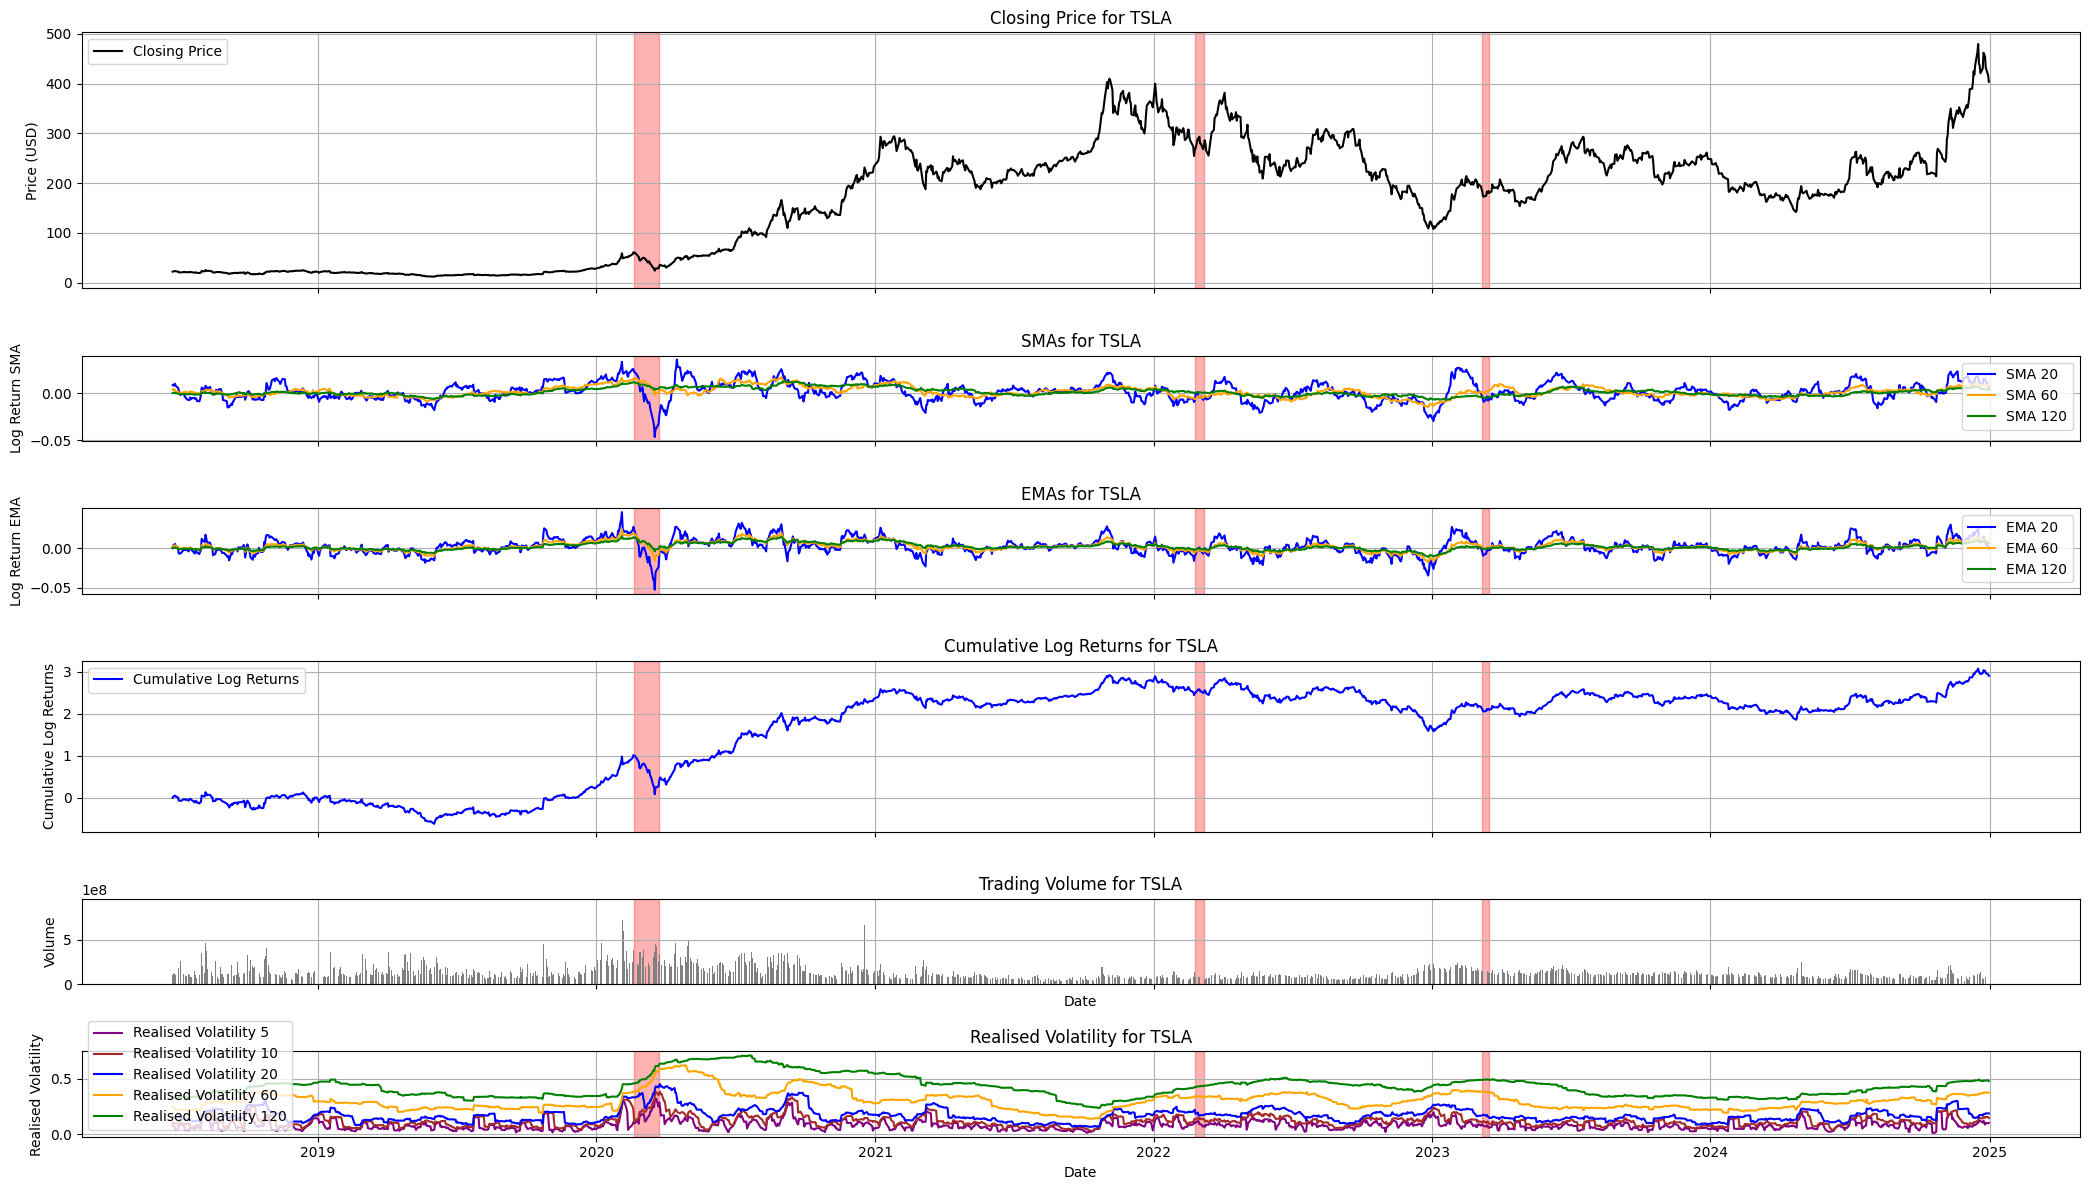

In [134]:
# Visualize volatility for a sample ticker
start_date = "2018-01-01"
end_date = "2024-12-31"
volatility_visual(sp_500_data, "TSLA", start_date, end_date)

Constructing an equal-weighted portfolio of the assets and comparing it with our benchmark

Correlation between Equal Weighted Portfolio and SPY Benchmark: 0.9321


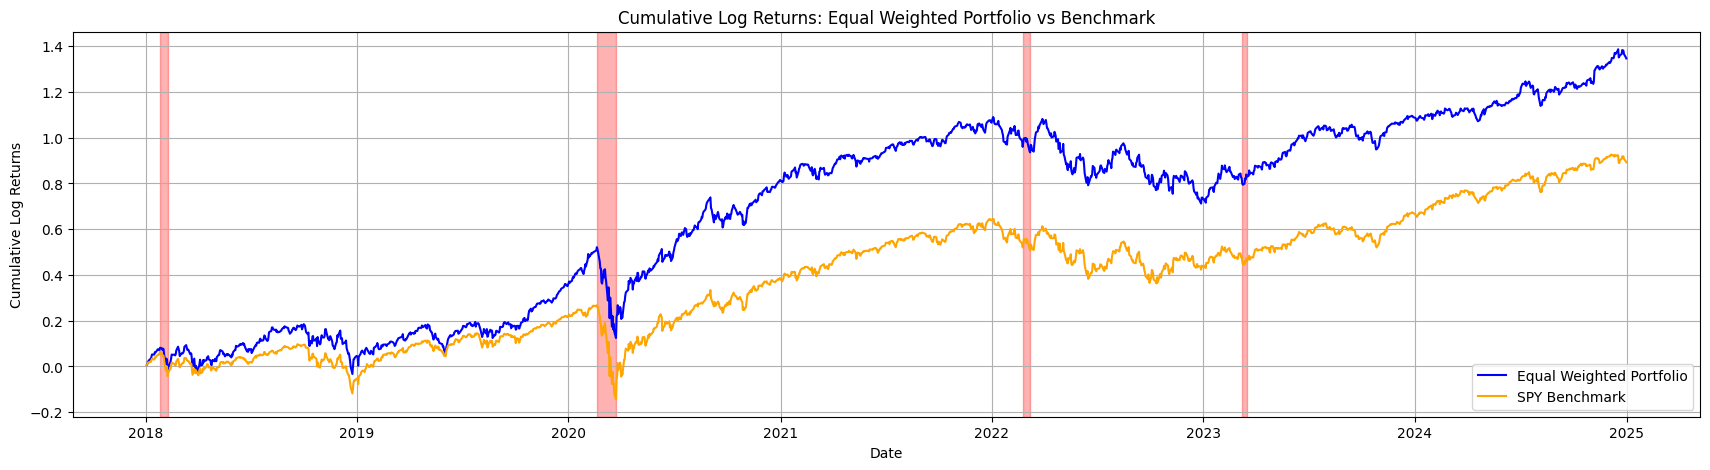

In [135]:
def equal_weighted_portfolio(dataset, start_date, end_date):
  df = pd.DataFrame()
  for ticker in dataset.keys():
    price_data = dataset[ticker]
    price_data = price_data[(price_data["Date"] >= start_date) & (price_data["Date"] <= end_date)]
    price_data.set_index("Date", inplace=True)
    if not price_data.empty:
      # Set the index to be date
      df.index = price_data.index
    df[ticker] = price_data["Close"]

  # Compute the log_returns for each ticker
  log_returns = np.log(df / df.shift(1))
  
  # Compute the equal weighted portfolio log returns
  log_returns["EW Portfolio"] = log_returns.mean(axis=1)
  return log_returns.dropna()


def benchmark_comparison(portfolio_returns, benchmark_dataframe, start_date, end_date):
  # Retrieve benchmark data
  bm = benchmark_dataframe.copy()
  bm = bm[(bm["Date"] >= start_date) & (bm["Date"] <= end_date)]
  bm["Benchmark Return"] = np.log(bm["Close"] / bm["Close"].shift(1))
  bm.dropna(inplace=True)
  bm.set_index("Date", inplace=True)
  
  # Combine the portfolio returns with benchmark returns
  combined = pd.DataFrame()
  combined['EW Portfolio'] = portfolio_returns["EW Portfolio"]
  combined['Benchmark Return'] = bm['Benchmark Return']
  combined.index = portfolio_returns.index.intersection(bm.index)
  
  # Print the correlation between the two
  correlation = combined.corr().iloc[0, 1]
  print(f"Correlation between Equal Weighted Portfolio and {benchmark_symbol} Benchmark: {correlation:.4f}")
  
  # Plot the return charts
  fig, ax = plt.subplots(figsize=(21, 5))
  
  ax.plot(combined.index, combined["EW Portfolio"].cumsum(), label="Equal Weighted Portfolio", color="blue")
  ax.plot(combined.index, combined["Benchmark Return"].cumsum(), label=f"{benchmark_symbol} Benchmark", color="orange")
  ax.set_title("Cumulative Log Returns: Equal Weighted Portfolio vs Benchmark")
  ax.set_xlabel("Date")
  ax.set_ylabel("Cumulative Log Returns")
  ax.legend()
  ax.grid()
  
  # Include the macro shocks as vertical boxes
  for shock, (start_date, end_date) in macro_shocks.items():
    # Convert to datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Check if dates are in the plotting range
    if start >= combined.index.min() and end <= combined.index.max():
      ax.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
   
  plt.show()

ew_portfolio = equal_weighted_portfolio(sp_500_data, start_date, end_date)
benchmark_comparison(ew_portfolio, spy_data[benchmark_symbol], start_date, end_date)


We notice the higher returns of our equal-weighted portfolio vs our benchmark as shown from the chart above. In addition, the movements are generally correlated with a ```corr(SPY, Portfolio)=0.9321```

Now, let us compare their volatilities over this period of time, with the inclusion of the macro-shocks

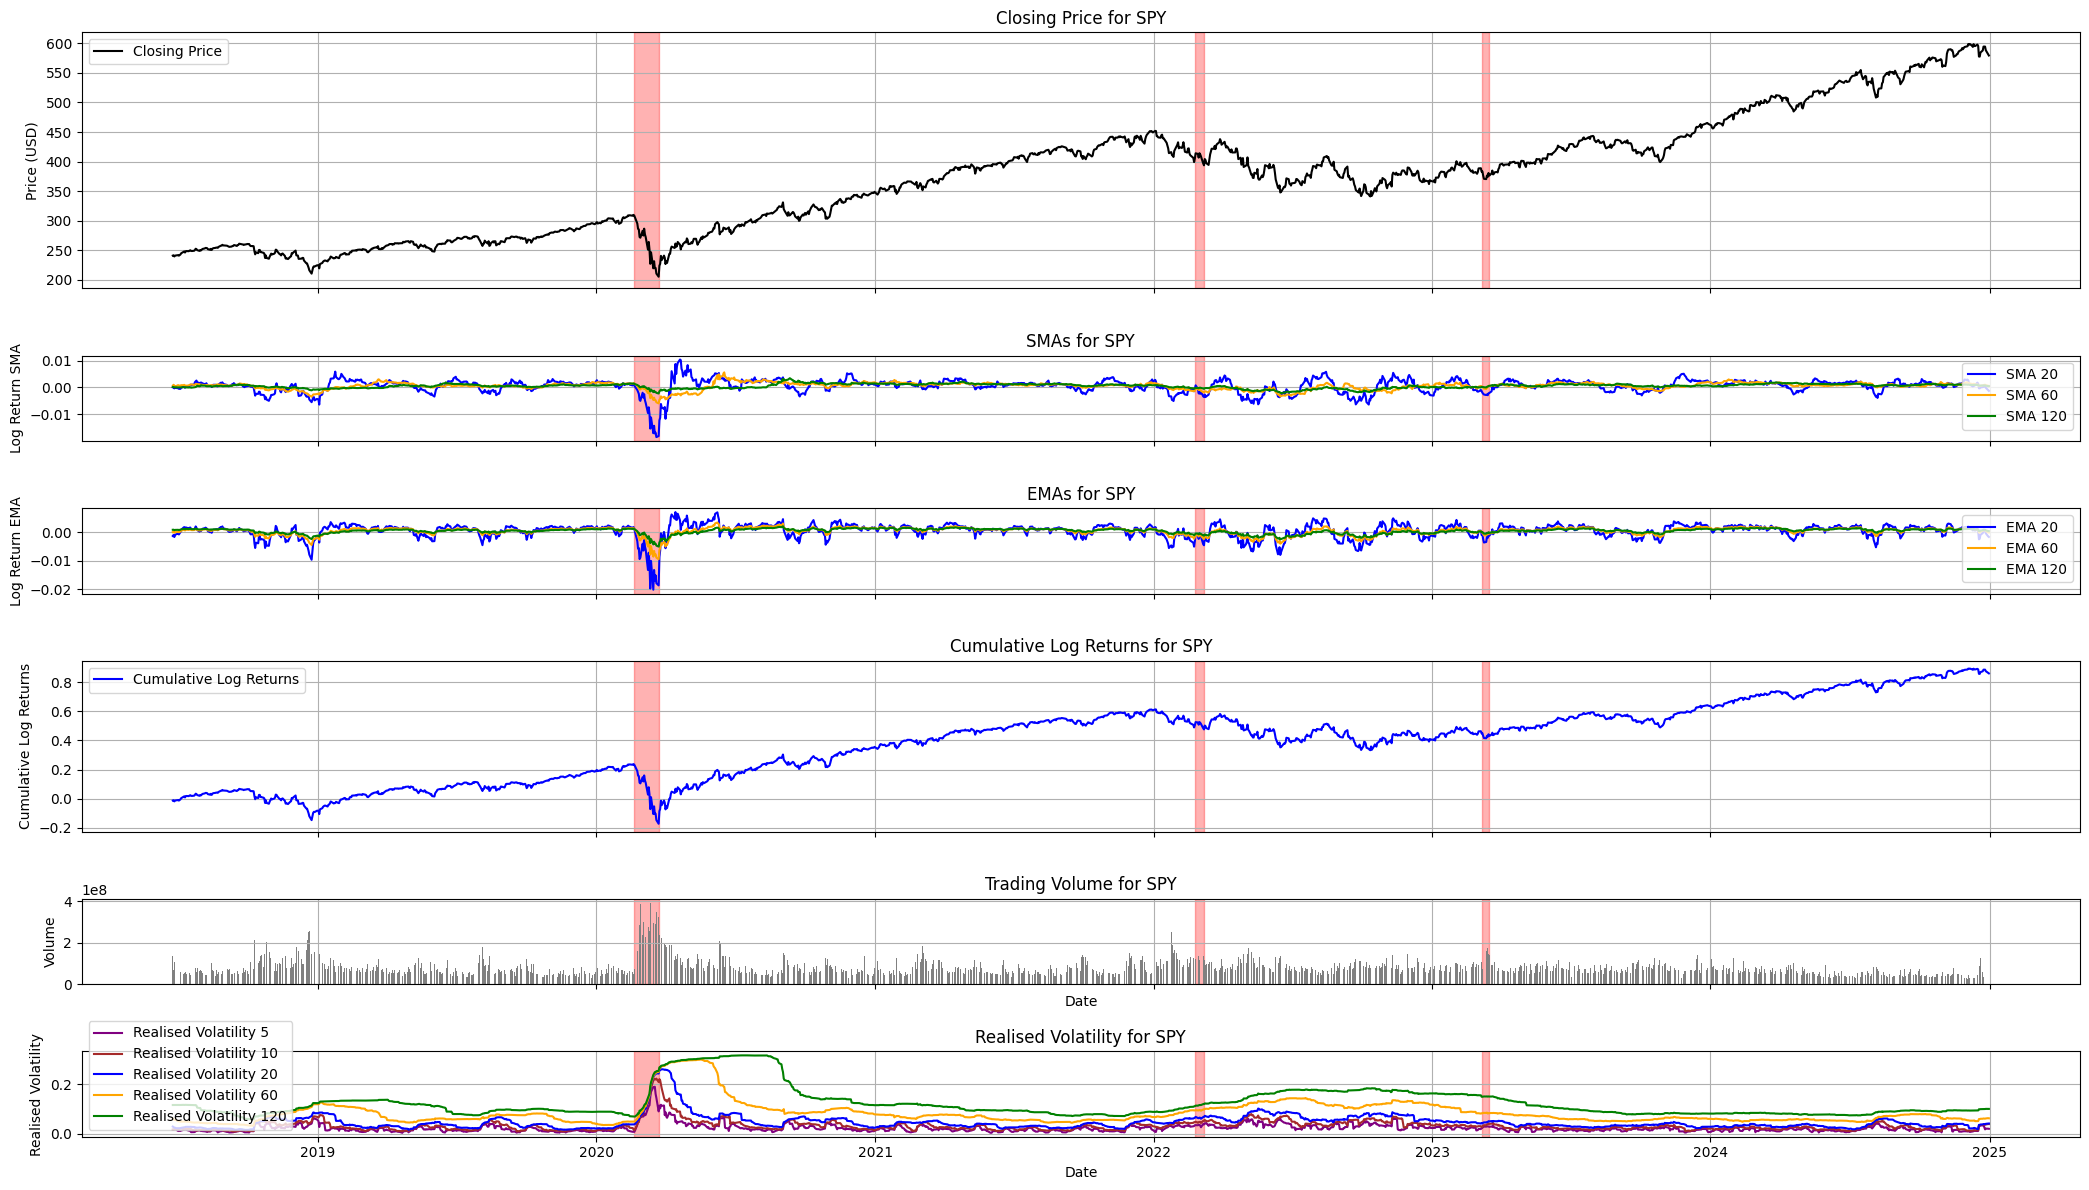

In [136]:
# Plot the volatility visual for the benchmark
volatility_visual(spy_data, benchmark_symbol, start_date, end_date)

In [137]:
def portfolio_volatility_visual(portfolio_return, start_date, end_date):
  # Make a copy of the dataframe
  df = portfolio_return.copy()
  
  # Subset the data for the specified date range
  df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
  df.set_index("Date", inplace=True)
    
  # Compute the SMAs of varying windows
  sma_20 = compute_sma(df, window=20)
  sma_60 = compute_sma(df, window=60)
  sma_120 = compute_sma(df, window=120)
  
  # Calculate the EWMA with varying spans
  ema_20 = compute_ema(df, span=20)
  ema_60 = compute_ema(df, span=60)
  ema_120 = compute_ema(df, span=120)
  
  # Compute the realised volatility
  rv_5 = realised_volatility(df, window=5)
  rv_10 = realised_volatility(df, window=10)
  rv_20 = realised_volatility(df, window=20)
  rv_60 = realised_volatility(df, window=60)
  rv_120 = realised_volatility(df, window=120)
  
  # 4 subplots for our portfolio stacked vertically, making each subplot having a different aspect of the data
  fig, axs = plt.subplots(4, 1, figsize=(21, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 2]})  # adjust each row's height
  
  # Concat all the SMAs and EMAs with our price data for plotting and drop NA values
  plot_data = pd.concat([df, sma_20, sma_60, sma_120, ema_20, ema_60, ema_120, rv_5, rv_10, rv_20, rv_60, rv_120], axis=1).dropna()
  plot_data.columns = [
    "Log Return", "SMA 20", "SMA 60", "SMA 120", "EMA 20", "EMA 60", "EMA 120", "Realised Volatility 5", 
    "Realised Volatility 10", "Realised Volatility 20", "Realised Volatility 60", "Realised Volatility 120"
  ]
  plot_data.reset_index(inplace=True)
  
  # First chart will be the cumulative returns of the portfolio
  axs[0].plot(plot_data["Date"], plot_data["Log Return"].cumsum(), label="Cumulative Log Returns", color="black")
  
  # Include the macro shocks as vertical boxes
  for shock, (start_date, end_date) in macro_shocks.items():
    # Convert to datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Check if dates are in the plotting range
    if start >= plot_data["Date"].min() and end <= plot_data["Date"].max():  
      axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[2].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[3].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
  
  axs[0].set_title(f"Cumulative Log Returns for Portfolio")
  axs[0].set_ylabel("Log Return")
  axs[0].grid()
  axs[0].legend()
  
  # Second chart will be SMAs
  axs[1].plot(plot_data["Date"], plot_data["SMA 20"], label="SMA 20", color="blue")
  axs[1].plot(plot_data["Date"], plot_data["SMA 60"], label="SMA 60", color="orange")
  axs[1].plot(plot_data["Date"], plot_data["SMA 120"], label="SMA 120", color="green")
  axs[1].set_title(f"SMAs for Portfolio")
  axs[1].set_ylabel("Log Return SMA")
  axs[1].grid()
  axs[1].legend()
  
  # Third chart will be EMAs
  axs[2].plot(plot_data["Date"], plot_data["EMA 20"], label="EMA 20", color="blue")
  axs[2].plot(plot_data["Date"], plot_data["EMA 60"], label="EMA 60", color="orange")
  axs[2].plot(plot_data["Date"], plot_data["EMA 120"], label="EMA 120", color="green")
  axs[2].set_title(f"EMAs for Portfolio")
  axs[2].set_ylabel("Log Return EMA")
  axs[2].grid()
  axs[2].legend()

  # Fourth chart will be realised volatility
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 5"], label="Realised Volatility 5", color="purple")
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 10"], label="Realised Volatility 10", color="brown")
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 20"], label="Realised Volatility 20", color="blue")
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 60"], label="Realised Volatility 60", color="orange")
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 120"], label="Realised Volatility 120", color="green")
  axs[3].set_title(f"Realised Volatility for Portfolio")
  axs[3].set_ylabel("Realised Volatility")
  axs[3].set_xlabel("Date")
  axs[3].grid()
  axs[3].legend()
  
  plt.tight_layout()
  plt.show()
  
  
  
# Concise visualization for the benchmark
def benchmark_volatility_visual(benchmark_return, start_date, end_date):
  # Make a copy of the dataframe
  df = benchmark_return.copy()
  
  # Subset the data for the specified date range
  df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
  df.set_index("Date", inplace=True)
    
  # Compute the SMAs of varying windows
  sma_20 = compute_sma(df, window=20)
  sma_60 = compute_sma(df, window=60)
  sma_120 = compute_sma(df, window=120)
  
  # Calculate the EWMA with varying spans
  ema_20 = compute_ema(df, span=20)
  ema_60 = compute_ema(df, span=60)
  ema_120 = compute_ema(df, span=120)
  
  # Compute the realised volatility
  rv_5 = realised_volatility(df, window=5)
  rv_10 = realised_volatility(df, window=10)
  rv_20 = realised_volatility(df, window=20)
  rv_60 = realised_volatility(df, window=60)
  rv_120 = realised_volatility(df, window=120)
  
  # 4 subplots for our benchmark stacked vertically, making each subplot having a different aspect of the data
  fig, axs = plt.subplots(4, 1, figsize=(21, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 2]})  # adjust each row's height
  
  # Concat all the SMAs and EMAs with our price data for plotting and drop NA values
  plot_data = pd.concat([df, sma_20, sma_60, sma_120, ema_20, ema_60, ema_120, rv_5, rv_10, rv_20, rv_60, rv_120], axis=1).dropna()
  plot_data.columns = [
    "Log Return", "SMA 20", "SMA 60", "SMA 120", "EMA 20", "EMA 60", "EMA 120", "Realised Volatility 5", 
    "Realised Volatility 10", "Realised Volatility 20", "Realised Volatility 60", "Realised Volatility 120"
  ]
  plot_data.reset_index(inplace=True)
  
  # First chart will be the cumulative returns of the benchmark
  axs[0].plot(plot_data["Date"], plot_data["Log Return"].cumsum(), label="Cumulative Log Returns", color="black")
  
  # Include the macro shocks as vertical boxes
  for shock, (start_date, end_date) in macro_shocks.items():
    # Convert to datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Check if dates are in the plotting range
    if start >= plot_data["Date"].min() and end <= plot_data["Date"].max():  
      axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[2].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
      axs[3].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color="red", alpha=0.3)
  
  axs[0].set_title(f"Cumulative Log Returns for Benchmark")
  axs[0].set_ylabel("Log Return")
  axs[0].grid()
  axs[0].legend()
  
  # Second chart will be SMAs
  axs[1].plot(plot_data["Date"], plot_data["SMA 20"], label="SMA 20", color="blue")
  axs[1].plot(plot_data["Date"], plot_data["SMA 60"], label="SMA 60", color="orange")
  axs[1].plot(plot_data["Date"], plot_data["SMA 120"], label="SMA 120", color="green")
  axs[1].set_title(f"SMAs for Benchmark")
  axs[1].set_ylabel("Log Return SMA")
  axs[1].grid()
  axs[1].legend()
  
  # Third chart will be EMAs
  axs[2].plot(plot_data["Date"], plot_data["EMA 20"], label="EMA 20", color="blue")
  axs[2].plot(plot_data["Date"], plot_data["EMA 60"], label="EMA 60", color="orange")
  axs[2].plot(plot_data["Date"], plot_data["EMA 120"], label="EMA 120", color="green")
  axs[2].set_title(f"EMAs for Benchmark")
  axs[2].set_ylabel("Log Return EMA")
  axs[2].grid()
  axs[2].legend()

  # Fourth chart will be realised volatility
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 5"], label="Realised Volatility 5", color="purple")
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 10"], label="Realised Volatility 10", color="brown")
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 20"], label="Realised Volatility 20", color="blue")
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 60"], label="Realised Volatility 60", color="orange")
  axs[3].plot(plot_data["Date"], plot_data["Realised Volatility 120"], label="Realised Volatility 120", color="green")
  axs[3].set_title(f"Realised Volatility for Benchmark")
  axs[3].set_ylabel("Realised Volatility")
  axs[3].set_xlabel("Date")
  axs[3].grid()
  axs[3].legend()
  
  plt.tight_layout()
  plt.show()


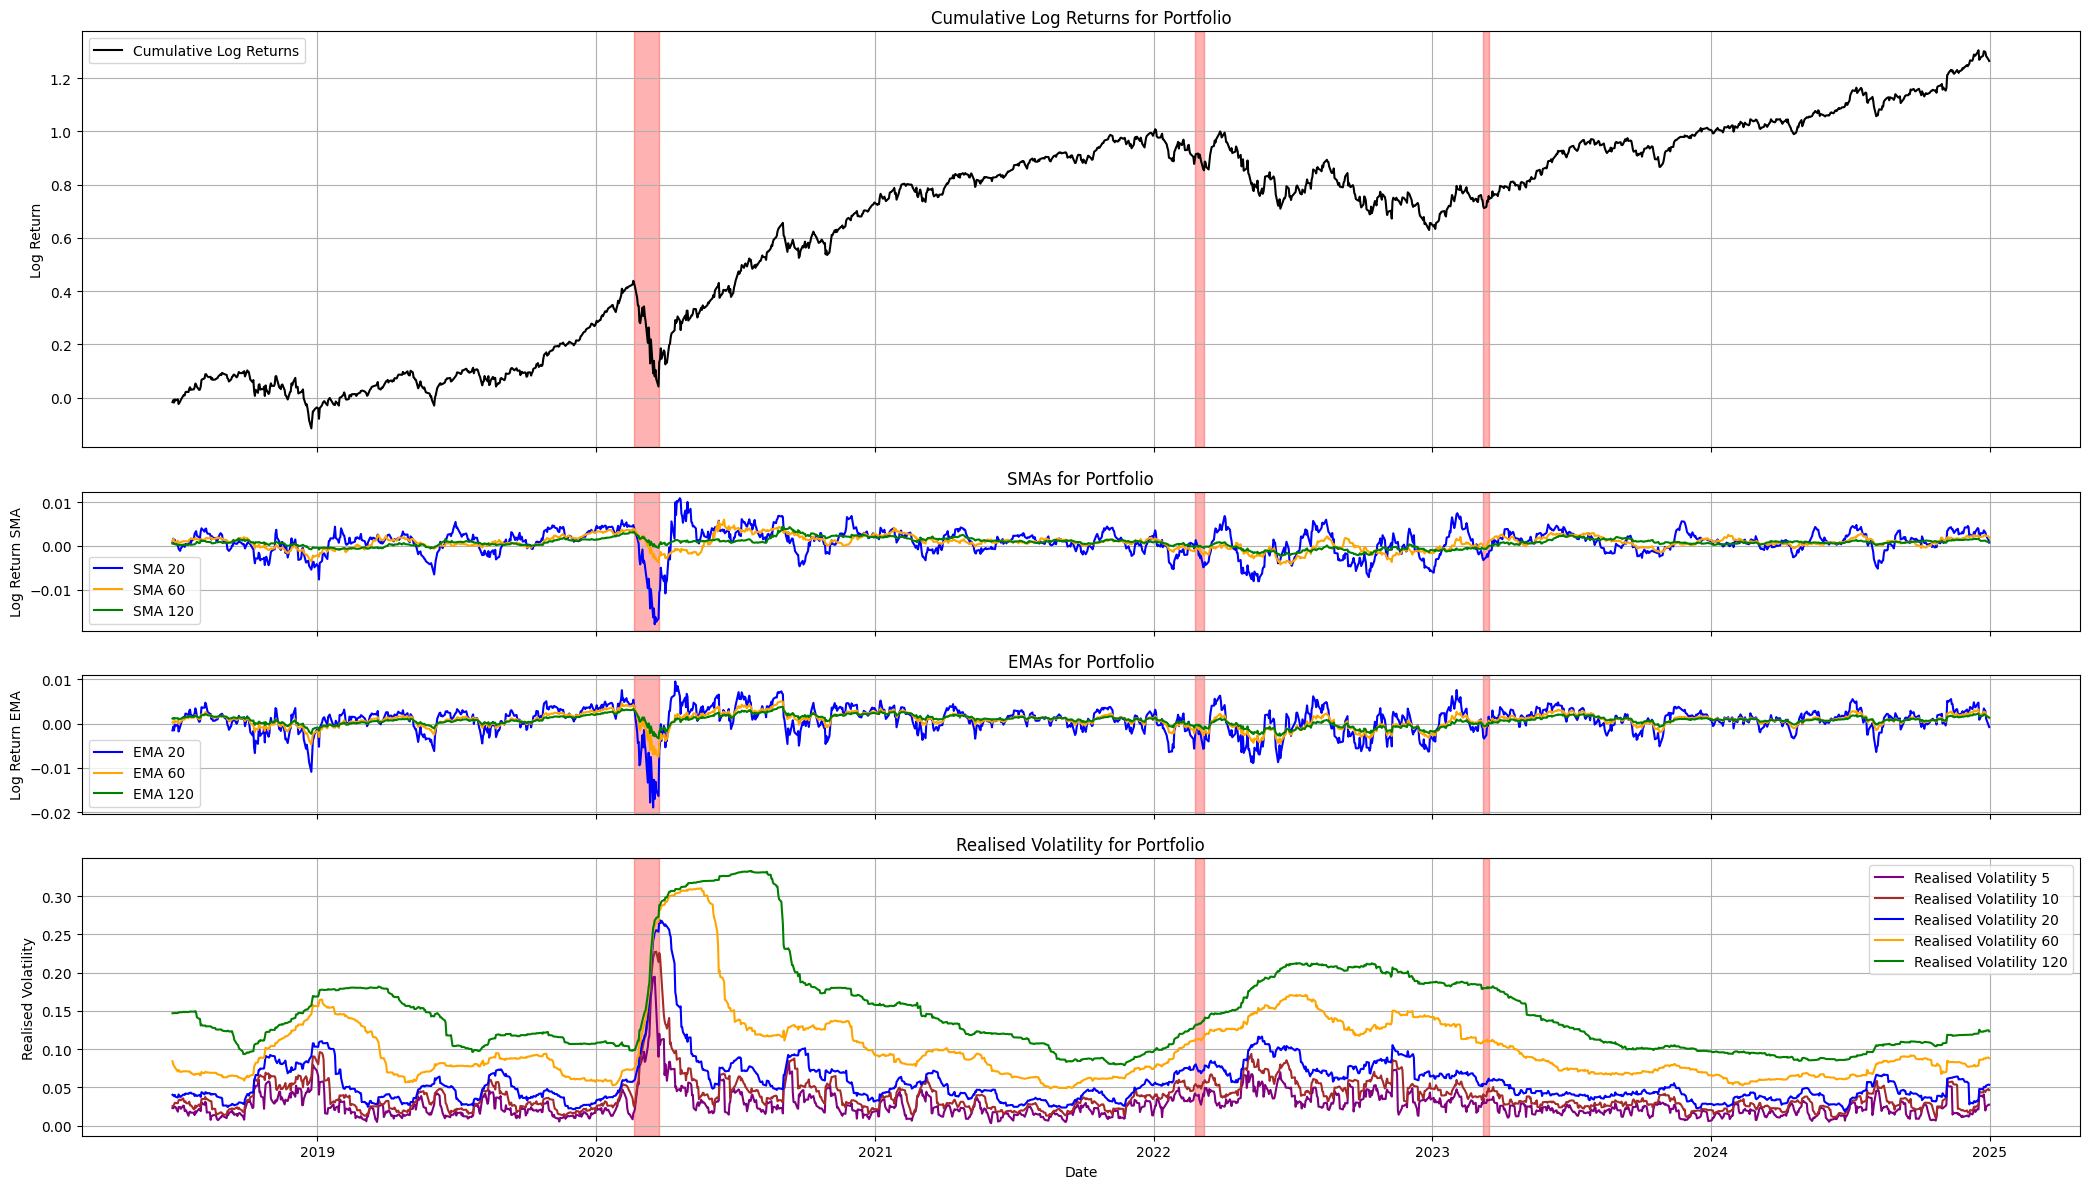

In [138]:
# Plot the volatility visual for the portfolio
ew_portfolio.rename(columns={"EW Portfolio": "Log Return"}, inplace=True)
ew_portfolio.reset_index(inplace=True, drop=False)
portfolio_volatility_visual(ew_portfolio[['Date','Log Return']], start_date, end_date)

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2330/2402019879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_return.dropna(inplace=True)


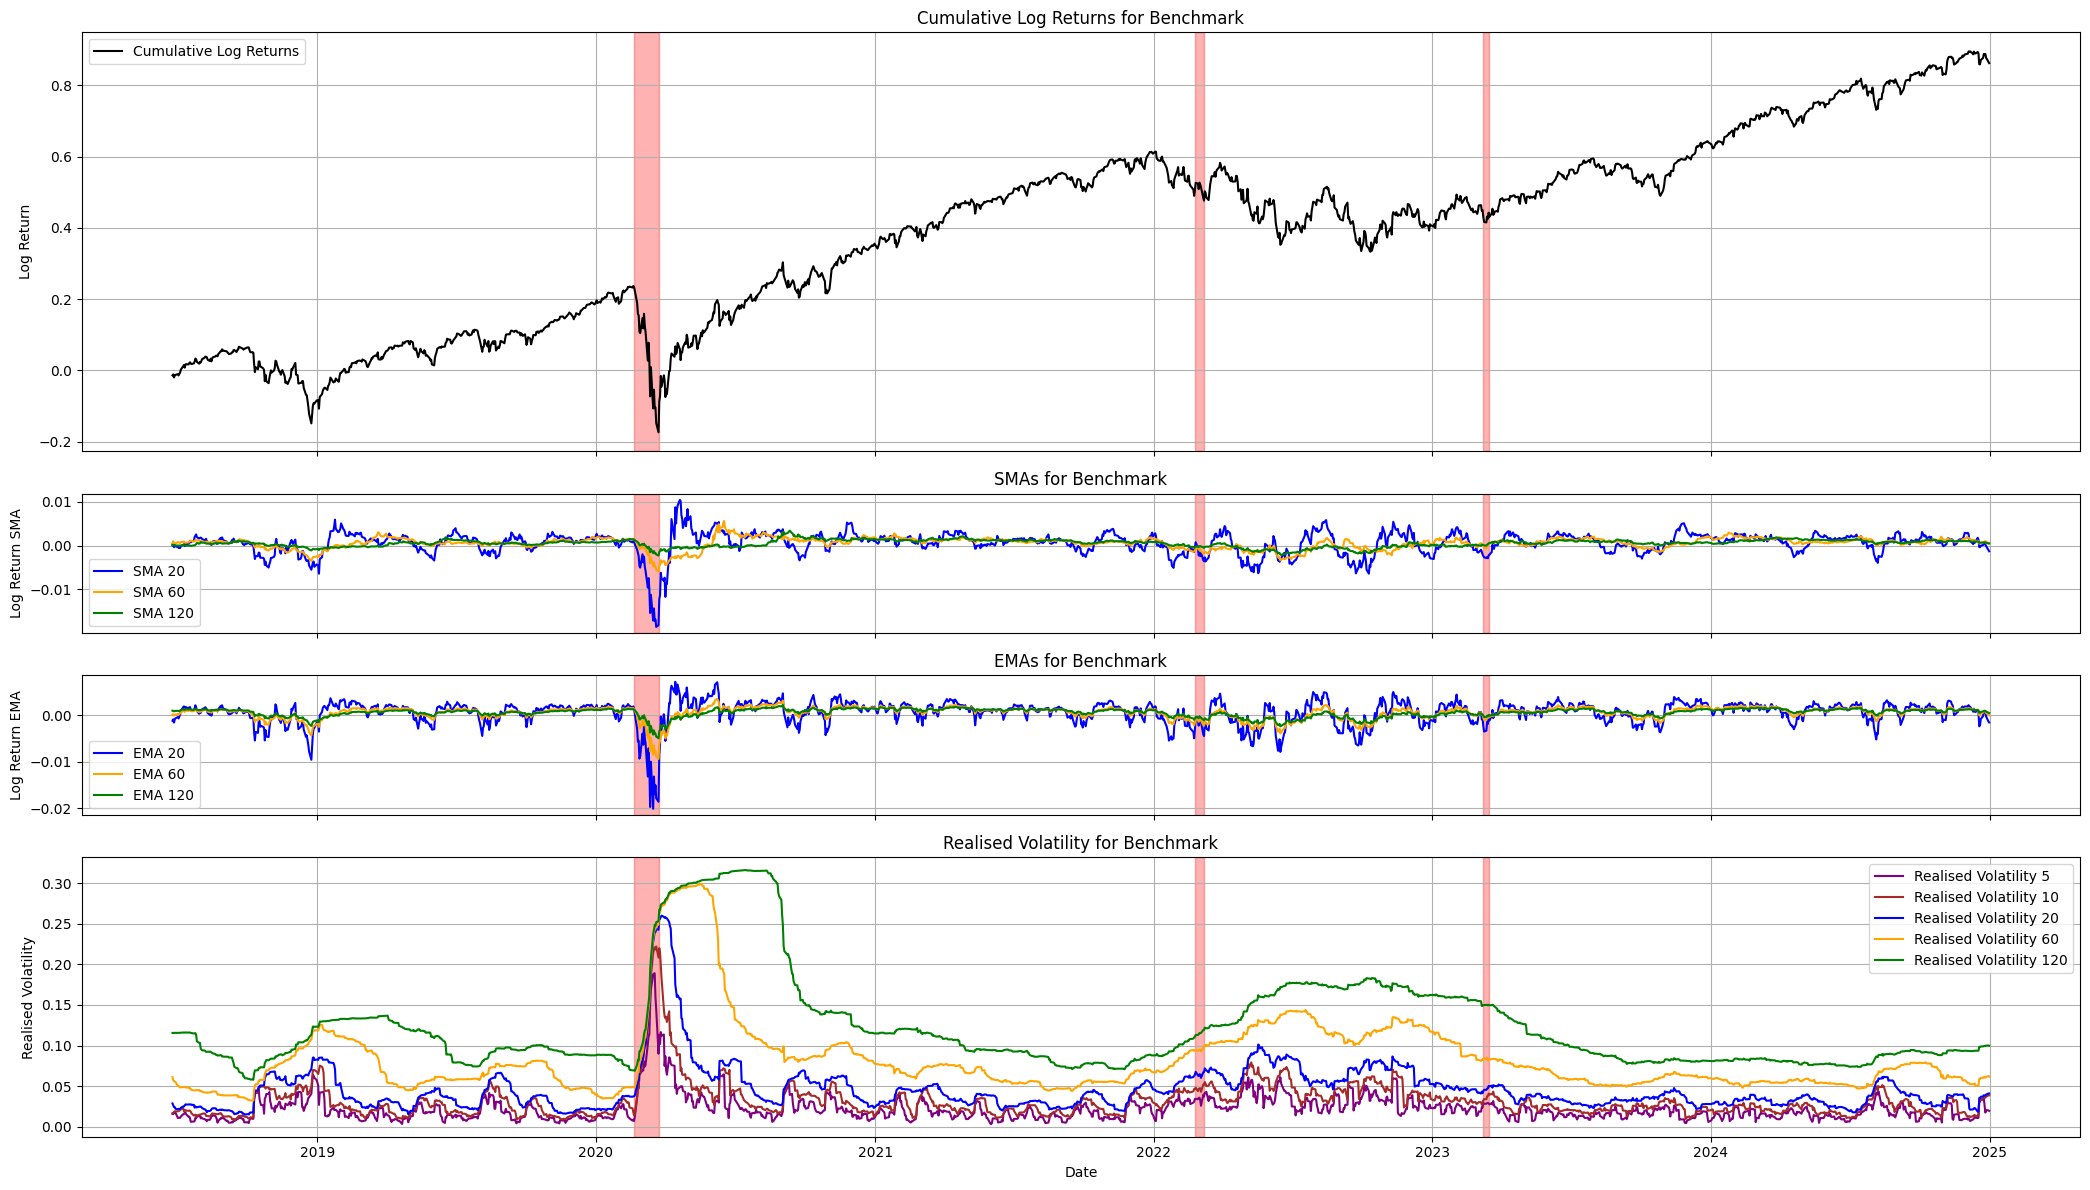

In [139]:
benchmark_copy = spy_data[benchmark_symbol].copy()
benchmark_copy['Log Return'] = np.log(benchmark_copy['Close'] / benchmark_copy['Close'].shift(1))
benchmark_copy.reset_index(inplace=True, drop=False)
benchmark_return = benchmark_copy[['Date','Log Return']]
benchmark_return.dropna(inplace=True)
benchmark_volatility_visual(benchmark_return, start_date, end_date)

Now we can see some differences between our portfolio and benchmark in terms of volatility across time. Do adjust the timeframes (start and end dates) to see how volatility varies during different time periods!

With that, we will end off this section with some analysis of the portfolio's performance against the benchmark

In [142]:
# Combine the portfolio and benchmark returns
from sklearn import metrics


def combined_portfolio_benchmark_volatility_visual(portfolio_data, benchmark_dataframe, start_date, end_date):
  rets_df = pd.DataFrame()
  # Make a copy of the dataframe
  ew_portfolio = equal_weighted_portfolio(portfolio_data, start_date, end_date)
  ew_portfolio.reset_index(inplace=True, drop=False)
  ew_portfolio.rename(columns={"EW Portfolio": "Log Return"}, inplace=True)
  df = ew_portfolio.copy()
  df.dropna(inplace=True)
  df_bm = benchmark_dataframe.copy()
  df_bm = df_bm[(df_bm["Date"] >= start_date) & (df_bm["Date"] <= end_date)]
  
  # Concat the returns dataframes with matching dates only
  rets_df = pd.merge(df, df_bm, on="Date", how="inner")
  rets_df = rets_df[['Date', 'Log Return', 'Benchmark Return']]
  rets_df.rename(columns={"Log Return": "Portfolio Log Returns"}, inplace=True)
  
  # Compute some volatility measures such as standard deviation, beta, R-squared, and alpha
  metrics = pd.DataFrame(
    index=['Cumulative Return', 'Standard Deviation', 'Beta', 'Sharpe Ratio', 'Alpha', 'R-squared'],
    columns=['Portfolio', 'Benchmark']
  )
  
  # Cumulative Return
  metrics.at['Cumulative Return', 'Portfolio'] = rets_df['Portfolio Log Returns'].sum()
  metrics.at['Cumulative Return', 'Benchmark'] = rets_df['Benchmark Return'].sum() 
  
  # Standard Deviation
  metrics.at['Standard Deviation', 'Portfolio'] = rets_df['Portfolio Log Returns'].std()
  metrics.at['Standard Deviation', 'Benchmark'] = rets_df['Benchmark Return'].std()
  metrics.at['Sharpe Ratio', 'Portfolio'] = rets_df['Portfolio Log Returns'].mean() / rets_df['Portfolio Log Returns'].std() * np.sqrt(252)
  metrics.at['Sharpe Ratio', 'Benchmark'] = rets_df['Benchmark Return'].mean() / rets_df['Benchmark Return'].std() * np.sqrt(252)

  # Beta
  covariance = rets_df[['Portfolio Log Returns', 'Benchmark Return']].cov()
  beta = covariance.loc['Portfolio Log Returns', 'Benchmark Return'] / covariance.loc['Benchmark Return', 'Benchmark Return']
  metrics.at['Beta', 'Portfolio'] = beta
  metrics.at['Beta', 'Benchmark'] = 1.0
  
  # Compute Alpha using OLS regression
  # set X and Y. Have to add constant
  X = rets_df[['Benchmark Return']] # Our independent variable
  X = sm.add_constant(X)  # Adds a constant term to the predictor
  Y = rets_df['Portfolio Log Returns'] # Our dependent variable
  
  results = sm.OLS(Y, X).fit()
  print(results.summary()) # Check the summary of our regression results
  
  """
  const is alpha
  Benchmark Returns is beta
  """
  print(f"Alpha: {results.params['const']}")
  print(f"Beta: {results.params['Benchmark Return']}")
  
  # Add the alpha values to our metrics dataframe
  metrics.at['Alpha', 'Portfolio'] = results.params['const']
  metrics.at['Alpha', 'Benchmark'] = 0.0
  
  # Add the R-squared value to our metrics dataframe
  metrics.at['R-squared', 'Portfolio'] = results.rsquared
  metrics.at['R-squared', 'Benchmark'] = 1.0
  
  # Generate the regression plot
  beta_contr = results.params['Benchmark Return']*X['Benchmark Return']
  prediction = results.params['Benchmark Return']*X['Benchmark Return'] + results.params['const']
  alpha_contr = results.params['const'] + results.resid
  
  # Ensure correlation to benchmark is low to confirm market-neutrality
  print("Correlation between strategy returns and benchmark returns:", alpha_contr.corr(X['Benchmark Return']))
  
  # Our 3 key metrics
  print("Alpha:", alpha_contr.mean()) # This is the average return of the strategy
  print("Information Ratio:", alpha_contr.mean()/alpha_contr.std()*np.sqrt(252)) # This is the information ratio of the strategy
  print("Alpha t-stat:", results.tvalues['const']) # This is the t-stat of alpha
  
  return metrics
  
  
spy_returns = spy_data[benchmark_symbol].copy()
spy_returns["Benchmark Return"] = np.log(spy_returns["Close"] / spy_returns["Close"].shift(1))
spy_returns.dropna(inplace=True)
spy_returns.reset_index(inplace=True, drop=False)

combined_portfolio_benchmark_volatility_visual(sp_500_data, spy_returns, start_date, end_date)

                              OLS Regression Results                             
Dep. Variable:     Portfolio Log Returns   R-squared:                       0.869
Model:                               OLS   Adj. R-squared:                  0.869
Method:                    Least Squares   F-statistic:                 1.165e+04
Date:                   Tue, 20 Jan 2026   Prob (F-statistic):               0.00
Time:                           23:19:42   Log-Likelihood:                 6744.3
No. Observations:                   1760   AIC:                        -1.348e+04
Df Residuals:                       1758   BIC:                        -1.347e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

,Portfolio,Benchmark
Cumulative Return,1.346598,0.892843
Standard Deviation,0.014481,0.012306
Beta,1.096866,1.0
Sharpe Ratio,0.838748,0.65441
Alpha,0.000209,0.0
R-squared,0.868851,1.0
